In [2]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

In [3]:
# Switch values if necessary 1 11 2021
#Dist_prism_12 = 1.0398341231585624*1000
#Dist_prism_13 = 0.818424700118086*1000
#Dist_prism_23 = 0.8806156053859284*1000
#Dist_GPS_12 = 0.835637436093363*1000
#Dist_GPS_13 = 0.7812173648662254*1000
#Dist_GPS_23 = 0.5166745729506486*1000

# 26 11 2021
#Dist_prism_12 = 1.03688797895733
#Dist_prism_13 = 0.822536135483593
#Dist_prism_23 = 0.8783765747673403
#Dist_GPS_12 = 0.7828618536473139
#Dist_GPS_13 = 0.8394208131018045
#Dist_GPS_23 = 0.5176447366930409

# 31 01 2022
#Dist_prism_12 = 1.038854051807371
#Dist_prism_13 = 0.8202157646292075
#Dist_prism_23 = 0.879788333022114
#Dist_GPS_12 = 0.7830826912858335
#Dist_GPS_13 = 0.8418404054627937
#Dist_GPS_23 = 0.5172558618541933
     
# 03 02 2022
#Dist_prism_12 = 1.0403741344089559
#Dist_prism_13 = 0.8239475424257701
#Dist_prism_23 = 0.8766711748547112
#Dist_GPS_12 = 0.781661929058067
#Dist_GPS_13 = 0.8353981332464246
#Dist_GPS_23 = 0.5174987476948135

# 17 02 2022 / 24 02 2022
Dist_prism_12_240222 = 0.8882613537922258
Dist_prism_13_240222 = 0.8262903370535766
Dist_prism_23_240222 = 1.0377436460567973
Dist_GPS_12_240222 = 0.7809786915630756
Dist_GPS_13_240222 = 0.8378323585433202
Dist_GPS_23_240222 = 0.5191788936274444   

# 07 03 2022
Dist_prism_12_070322 = 0.8832836583456264
Dist_prism_13_070322 = 0.8247449387008166
Dist_prism_23_070322 = 1.039409793600046
Dist_GPS_12_070322 = 0.7781099344563802
Dist_GPS_13_070322 = 0.8431026980109139
Dist_GPS_23_070322 = 0.5157221841320069

# 12 03 2022
Dist_prism_12_120322 = 0.8860734460339026
Dist_prism_13_120322 = 0.8303896290142598
Dist_prism_23_120322 = 1.0393117663247973
Dist_GPS_12_120322 = 0.7829424296161074
Dist_GPS_13_120322 = 0.8415176433032493
Dist_GPS_23_120322 = 0.5161917038941966

# 14 03 2022 / 16 03 2022
Dist_prism_12_140322 = 0.8873171656784946
Dist_prism_13_140322 = 0.8272212117473343
Dist_prism_23_140322 = 1.0379270641796363
Dist_GPS_12_140322 = 0.7829081036179948
Dist_GPS_13_140322 = 0.8424633975958637
Dist_GPS_23_140322 = 0.5165807364575292

# 31 03 2022
Dist_prism_12_310322 = 0.8873171656784946
Dist_prism_13_310322 = 0.8272212117473343
Dist_prism_23_310322 = 1.0379270641796363
Dist_GPS_12_310322 = 0.7829081036179948
Dist_GPS_13_310322 = 0.8424633975958637
Dist_GPS_23_310322 = 0.5165807364575292

Inter_distance = [[Dist_prism_12_240222,Dist_prism_13_240222,Dist_prism_23_240222,Dist_GPS_12_240222,Dist_GPS_13_240222,Dist_GPS_23_240222],
                 [Dist_prism_12_070322,Dist_prism_13_070322,Dist_prism_23_070322,Dist_GPS_12_070322,Dist_GPS_13_070322,Dist_GPS_23_070322],
                 [Dist_prism_12_120322,Dist_prism_13_120322,Dist_prism_23_120322,Dist_GPS_12_120322,Dist_GPS_13_120322,Dist_GPS_23_120322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_140322,Dist_prism_13_140322,Dist_prism_23_140322,Dist_GPS_12_140322,Dist_GPS_13_140322,Dist_GPS_23_140322],
                 [Dist_prism_12_310322,Dist_prism_13_310322,Dist_prism_23_310322,Dist_GPS_12_310322,Dist_GPS_13_310322,Dist_GPS_23_310322],]

print(Inter_distance[0])

[0.8882613537922258, 0.8262903370535766, 1.0377436460567973, 0.7809786915630756, 0.8378323585433202, 0.5191788936274444]


In [3]:
# Sort data for 2.5D plot
tfu = importlib.reload(tfu)
tfuu = importlib.reload(tfuu)
linear_speed_list = []
angular_speed_list = []
accel_list = []
mean_error_prisms_list = []

list_dataset_GP = ["./data/prediction/TS/20220224/", 
                   "./data/prediction/TS/20220307/", 
                   "./data/prediction/TS/20220312/",
                   "./data/prediction/TS/20220314/", 
                   "./data/prediction/TS/20220316/", 
                   "./data/prediction/TS/20220331-1/",
                   "./data/prediction/TS/20220331-2/"]

list_calib = ["./data/total_station/20220224/20220224_theodolite_reference_prisms.txt",
              "./data/total_station/20220307/theodolite_reference_prisms.txt",
              "./data/total_station/20220312/theodolite_reference_prisms.txt",
              "./data/total_station/20220314/theodolite_reference_prisms.txt",
              "./data/total_station/20220316/theodolite_reference_prisms.txt",
              "./data/total_station/20220331-1/theodolite_reference_prisms.txt",
              "./data/total_station/20220331-2/theodolite_reference_prisms.txt"]

list_rosbag = ["/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag",
               "/home/norlab/Data/IROS_2022/20220307_TS/2022-03-07-19-20-06.bag",
               "/home/norlab/Data/IROS_2022/20220312_TS/2022-03-12-09-45-12.bag",
               "/home/norlab/Data/IROS_2022/20220314_TS/2022-03-14-10-47-49.bag",
               "/home/norlab/Data/IROS_2022/20220316_TS/2022-03-16-19-02-42.bag",
               "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-10-22-52.bag",
               "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-11-20-05.bag"]

speed_l = []
angular_l = []
accel_l = []
error_l = []
for path,file_rosbag_theodolite,inter_dist in zip(list_dataset_GP,list_rosbag, Inter_distance):
    linear_speed_list, angular_speed_list, accel_list, mean_error_prisms_list = tfu.process_data_TS(path, inter_dist, file_rosbag_theodolite)
    speed_l = speed_l + linear_speed_list
    angular_l = angular_l + angular_speed_list
    accel_l = accel_l + accel_list
    error_l = error_l + mean_error_prisms_list
    print(len(error_l))

Linear velocity reading
Angular velocity reading
Finish !
33621
Linear velocity reading
Angular velocity reading
Finish !
78576
Linear velocity reading
Angular velocity reading
Finish !
128112
Linear velocity reading
Angular velocity reading
Finish !
177618
Linear velocity reading
Angular velocity reading
Finish !
213792
Linear velocity reading
Angular velocity reading
Finish !
239427


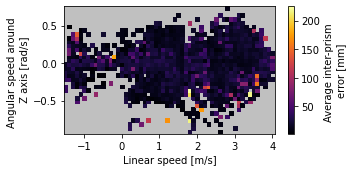

In [7]:
#print(linear_speed_list)
#print(angular_speed_list)
#print(mean_error_prisms_list)
# make these smaller to increase the resolution
tfu = importlib.reload(tfu)
dx, dy = 0.1, 0.05
save_fig = True
#name_file = "grid_plot_linear_angular_velocities_ski_trail.jpg"
name_file = "./figs/speed_rotations.pdf"
tfu.plot_grid_speed_angular_result(dx, dy, error_l, speed_l, angular_l, save_fig, name_file, True, 0)
#tfu.plot_grid_speed_angular_result(dx, dy, mean_error_prisms_list, accel_list, angular_speed_list, save_fig, name_file, False, 0)

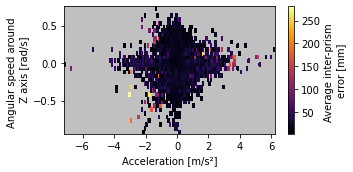

In [8]:
name_file = "./figs/accel_rotations.pdf"
dx, dy = .3, 0.05
save_fig = False
tfu.plot_grid_speed_angular_result(dx, dy, error_l, accel_l, angular_l, save_fig, name_file, False, 0)

In [ ]:
tfuu = importlib.reload(tfuu)
speed, accel = tfu.read_rosbag_imu_node(list_rosbag[0], True)

In [ ]:
tfuu = importlib.reload(tfuu)
angular_speed = tfuu.read_rosbag_imu_data(list_rosbag[0], True)
print(angular_speed[0])

In [ ]:
path = list_dataset_GP[0]
prefix = "GP-10-20"
P1 = np.array(tfu.read_prediction_data_csv_file(path + prefix + "_1.csv"))
P2 = np.array(tfu.read_prediction_data_csv_file(path + prefix + "_2.csv"))
P3 = np.array(tfu.read_prediction_data_csv_file(path + prefix + "_3.csv"))

dist_prism = []
origin = 0
for i in range(0, len(P1[:, 0])):
    dp1 = abs(np.linalg.norm(P1[i, 1:4] - P2[i, 1:4]) - Inter_distance[0][0])*1000
    dp2 = abs(np.linalg.norm(P1[i, 1:4] - P3[i, 1:4]) - Inter_distance[0][1])*1000
    dp3 = abs(np.linalg.norm(P3[i, 1:4] - P2[i, 1:4]) - Inter_distance[0][2])*1000
    dist_prism.append(np.array([P1[i, 0] - origin, dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

In [ ]:
print(speed[0])
print(dist_prism[0])
speed_arr = np.array(speed)
angular_arr = np.array(angular_speed)
dist_prism_arr = np.array(dist_prism)


In [ ]:
%matplotlib notebook
plt.figure(0)
plt.scatter(speed_arr[:,0], speed_arr[:,1], color='b')
plt.figure(0)
plt.scatter(angular_arr[:,0], angular_arr[:,1], color='g')
plt.figure(1)
plt.scatter(dist_prism_arr[:,0], dist_prism_arr[:,1], color='r')

In [24]:
tfuu = importlib.reload(tfuu)

file = ["/home/norlab/Data/IROS_2022/20220224_TS/2022-02-24-15-34-38.bag",
        "/home/norlab/Data/IROS_2022/20220307_TS/2022-03-07-19-20-06.bag",
        "/home/norlab/Data/IROS_2022/20220312_TS/2022-03-12-09-45-12.bag",
        "/home/norlab/Data/IROS_2022/20220314_TS/2022-03-14-10-47-49.bag",
        "/home/norlab/Data/IROS_2022/20220316_TS/2022-03-16-19-02-42.bag",
        "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-10-22-52.bag",
        "/home/norlab/Data/IROS_2022/20220331_TS/2022-03-31-11-20-05.bag"]

speed_list = []
accel_list = []
angular_list = []
for i in file:
    # Read rosbag for linear velocity
    print("Linear velocity reading")
    speed, accel, speed_only, accel_only = tfuu.read_rosbag_imu_node(i, True)
    # Read rosbag for angular velocity around Z
    angular_speed, angular_speed_only = tfuu.read_rosbag_imu_data(i, True)
    print("Angular velocity reading")
    speed_list.append(speed_only)
    accel_list.append(accel_only)
    angular_list.append(angular_speed_only)

Linear velocity reading
Angular velocity reading
Linear velocity reading
Angular velocity reading
Linear velocity reading
Angular velocity reading
Linear velocity reading
Angular velocity reading
Linear velocity reading
Angular velocity reading
Linear velocity reading
Angular velocity reading
Linear velocity reading
Angular velocity reading


 <>:8: DeprecationWarning:invalid escape sequence \l
 <>:8: DeprecationWarning:invalid escape sequence \s
 <>:9: DeprecationWarning:invalid escape sequence \l
 <>:9: DeprecationWarning:invalid escape sequence \s
 <>:10: DeprecationWarning:invalid escape sequence \l
 <>:10: DeprecationWarning:invalid escape sequence \s
 <>:11: DeprecationWarning:invalid escape sequence \l
 <>:11: DeprecationWarning:invalid escape sequence \s
 <>:12: DeprecationWarning:invalid escape sequence \l
 <>:12: DeprecationWarning:invalid escape sequence \s
 <>:13: DeprecationWarning:invalid escape sequence \l
 <>:13: DeprecationWarning:invalid escape sequence \s
 <>:14: DeprecationWarning:invalid escape sequence \l
 <>:14: DeprecationWarning:invalid escape sequence \s
 <>:8: DeprecationWarning:invalid escape sequence \l
 <>:8: DeprecationWarning:invalid escape sequence \s
 <>:9: DeprecationWarning:invalid escape sequence \l
 <>:9: DeprecationWarning:invalid escape sequence \s
 <>:10: DeprecationWarning:invalid e

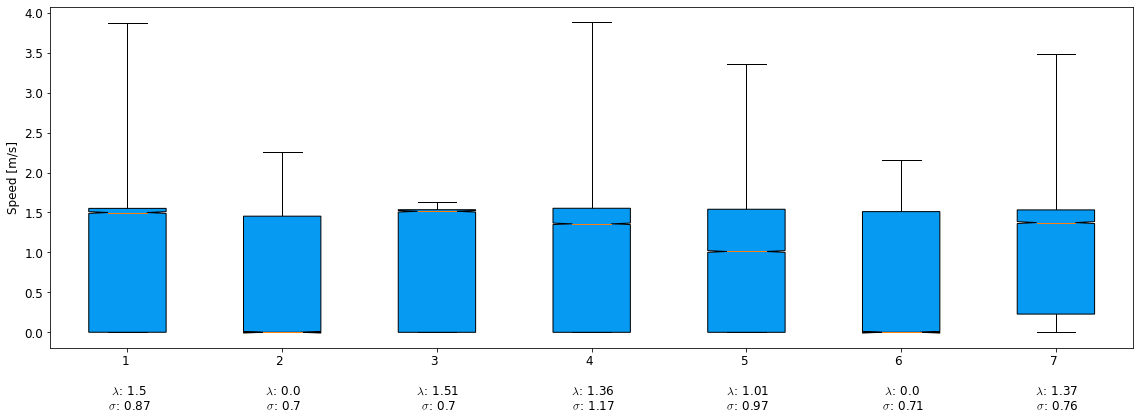

In [36]:
# Creating dataset
result = speed_list

fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)
box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7], [
                          "1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(np.std(result[0]),2)),
                          "2 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(np.std(result[1]),2)),
                          "3 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(np.std(result[2]),2)),
                          "4 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(np.std(result[3]),2)),
                          "5 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(np.std(result[4]),2)),
                          "6 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(np.std(result[5]),2)),
                          "7 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(np.std(result[6]),2)),
                          ])
colors_box = ['#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Speed [m/s]")
plt.show()
fig.tight_layout()
fig.savefig("./figs/speed_datasets.jpg")

 <>:8: DeprecationWarning:invalid escape sequence \l
 <>:8: DeprecationWarning:invalid escape sequence \s
 <>:9: DeprecationWarning:invalid escape sequence \l
 <>:9: DeprecationWarning:invalid escape sequence \s
 <>:10: DeprecationWarning:invalid escape sequence \l
 <>:10: DeprecationWarning:invalid escape sequence \s
 <>:11: DeprecationWarning:invalid escape sequence \l
 <>:11: DeprecationWarning:invalid escape sequence \s
 <>:12: DeprecationWarning:invalid escape sequence \l
 <>:12: DeprecationWarning:invalid escape sequence \s
 <>:13: DeprecationWarning:invalid escape sequence \l
 <>:13: DeprecationWarning:invalid escape sequence \s
 <>:14: DeprecationWarning:invalid escape sequence \l
 <>:14: DeprecationWarning:invalid escape sequence \s
 <>:8: DeprecationWarning:invalid escape sequence \l
 <>:8: DeprecationWarning:invalid escape sequence \s
 <>:9: DeprecationWarning:invalid escape sequence \l
 <>:9: DeprecationWarning:invalid escape sequence \s
 <>:10: DeprecationWarning:invalid e

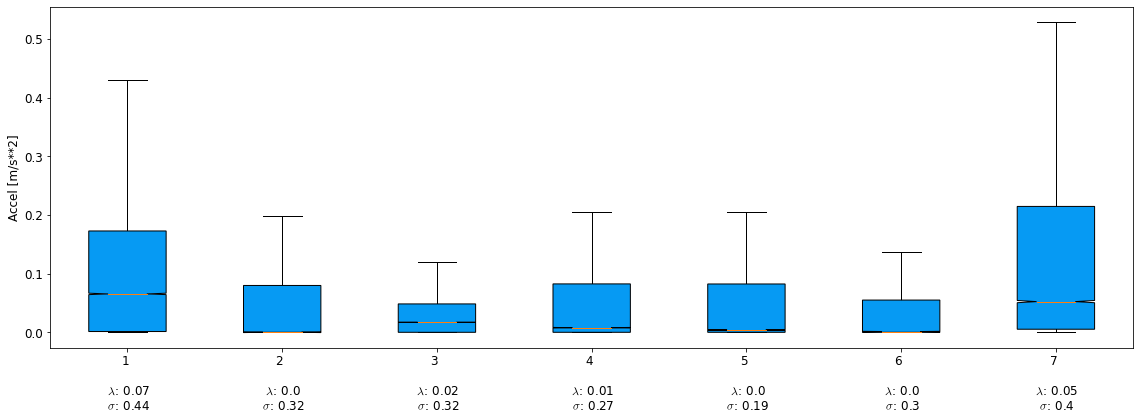

In [37]:
# Creating dataset
result = accel_list

fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)
box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7], [
                          "1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(np.std(result[0]),2)),
                          "2 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(np.std(result[1]),2)),
                          "3 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(np.std(result[2]),2)),
                          "4 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(np.std(result[3]),2)),
                          "5 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(np.std(result[4]),2)),
                          "6 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(np.std(result[5]),2)),
                          "7 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(np.std(result[6]),2)),
                          ])
colors_box = ['#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Accel [m/s**2]")
plt.show()
fig.tight_layout()
fig.savefig("./figs/accel_datasets.jpg")

 <>:8: DeprecationWarning:invalid escape sequence \l
 <>:8: DeprecationWarning:invalid escape sequence \s
 <>:9: DeprecationWarning:invalid escape sequence \l
 <>:9: DeprecationWarning:invalid escape sequence \s
 <>:10: DeprecationWarning:invalid escape sequence \l
 <>:10: DeprecationWarning:invalid escape sequence \s
 <>:11: DeprecationWarning:invalid escape sequence \l
 <>:11: DeprecationWarning:invalid escape sequence \s
 <>:12: DeprecationWarning:invalid escape sequence \l
 <>:12: DeprecationWarning:invalid escape sequence \s
 <>:13: DeprecationWarning:invalid escape sequence \l
 <>:13: DeprecationWarning:invalid escape sequence \s
 <>:14: DeprecationWarning:invalid escape sequence \l
 <>:14: DeprecationWarning:invalid escape sequence \s
 <>:8: DeprecationWarning:invalid escape sequence \l
 <>:8: DeprecationWarning:invalid escape sequence \s
 <>:9: DeprecationWarning:invalid escape sequence \l
 <>:9: DeprecationWarning:invalid escape sequence \s
 <>:10: DeprecationWarning:invalid e

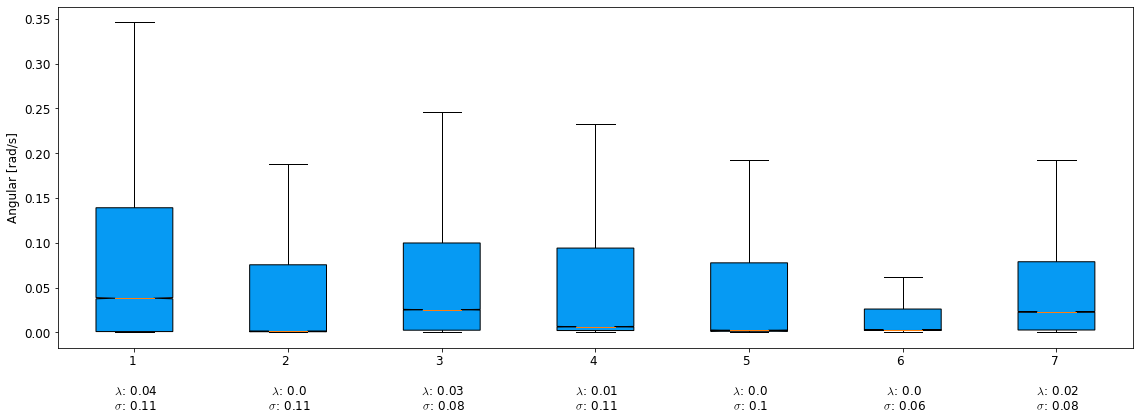

In [38]:
# Creating dataset
result = angular_list

fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)
box = ax.boxplot(result, notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7], [
                          "1 \n\n $\lambda$: "+str(round(np.median(result[0]),2))+" \n $\sigma$: "+str(round(np.std(result[0]),2)),
                          "2 \n\n $\lambda$: "+str(round(np.median(result[1]),2))+" \n $\sigma$: "+str(round(np.std(result[1]),2)),
                          "3 \n\n $\lambda$: "+str(round(np.median(result[2]),2))+" \n $\sigma$: "+str(round(np.std(result[2]),2)),
                          "4 \n\n $\lambda$: "+str(round(np.median(result[3]),2))+" \n $\sigma$: "+str(round(np.std(result[3]),2)),
                          "5 \n\n $\lambda$: "+str(round(np.median(result[4]),2))+" \n $\sigma$: "+str(round(np.std(result[4]),2)),
                          "6 \n\n $\lambda$: "+str(round(np.median(result[5]),2))+" \n $\sigma$: "+str(round(np.std(result[5]),2)),
                          "7 \n\n $\lambda$: "+str(round(np.median(result[6]),2))+" \n $\sigma$: "+str(round(np.std(result[6]),2)),
                          ])
colors_box = ['#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3', '#069AF3']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Angular [rad/s]")
plt.show()
fig.tight_layout()
fig.savefig("./figs/angular_datasets.jpg")